In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import utils.DataSplitter
import utils.Pytorch
from utils.tools import plotFitAndPredictions, plotLossCurves
from utils.metrics import *

## Define models

In [22]:
if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2, output_size=1, dropout_prob=0.1, bidirectional=True):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*self.directions, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*self.directions, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers*self.directions, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define the RNN model
class RNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=5, num_layers=2, output_size=1, dropout_prob=0.1, bidirectional=True):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.directions = 2 if bidirectional else 1

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*self.directions, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*self.directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

cuda


## Plot

In [58]:
# Change accordingly
aggLevel = 60
line = "1A"
diff = False
lags = [20, 40, 60, 80, 100, 120, 140]  # [i+1 for i in range(20)] + [40, 60, 80, 100, 120, 140]  # <-- To use all columns
dropWeather = True
dropCalendar = False

if aggLevel == 60:
    multiplier = 1
elif aggLevel == 30:
    multiplier = 2
elif aggLevel == 15:
    multiplier = 4
lags = [lag*multiplier for lag in lags]

X_train, y_train, X_val, y_val, y_train_true, y_val_true, lagColName, multiplier, train_orig, val_orig = utils.Pytorch.setupData(aggLevel,
                                                                                                                                 multiplier,
                                                                                                                                 line,
                                                                                                                                 diff,
                                                                                                                                 lags,
                                                                                                                                 dropWeather,
                                                                                                                                 dropCalendar)

In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
model = LSTM(hidden_size=100, num_layers=2, dropout_prob=0.5, bidirectional=True)
model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(utils.Pytorch.fixedWindowPytorch,
                                                                                                             X_train,
                                                                                                             y_train,
                                                                                                             X_val,
                                                                                                             y_val,
                                                                                                             y_train_true,
                                                                                                             y_val_true,
                                                                                                             model=model,
                                                                                                             batchSize=32,
                                                                                                             epochs=75,
                                                                                                             max_lr=1e-3,
                                                                                                             device=device,
                                                                                                             lagColName=lagColName,
                                                                                                             horizon=40*multiplier)

Forecast iteration: 46


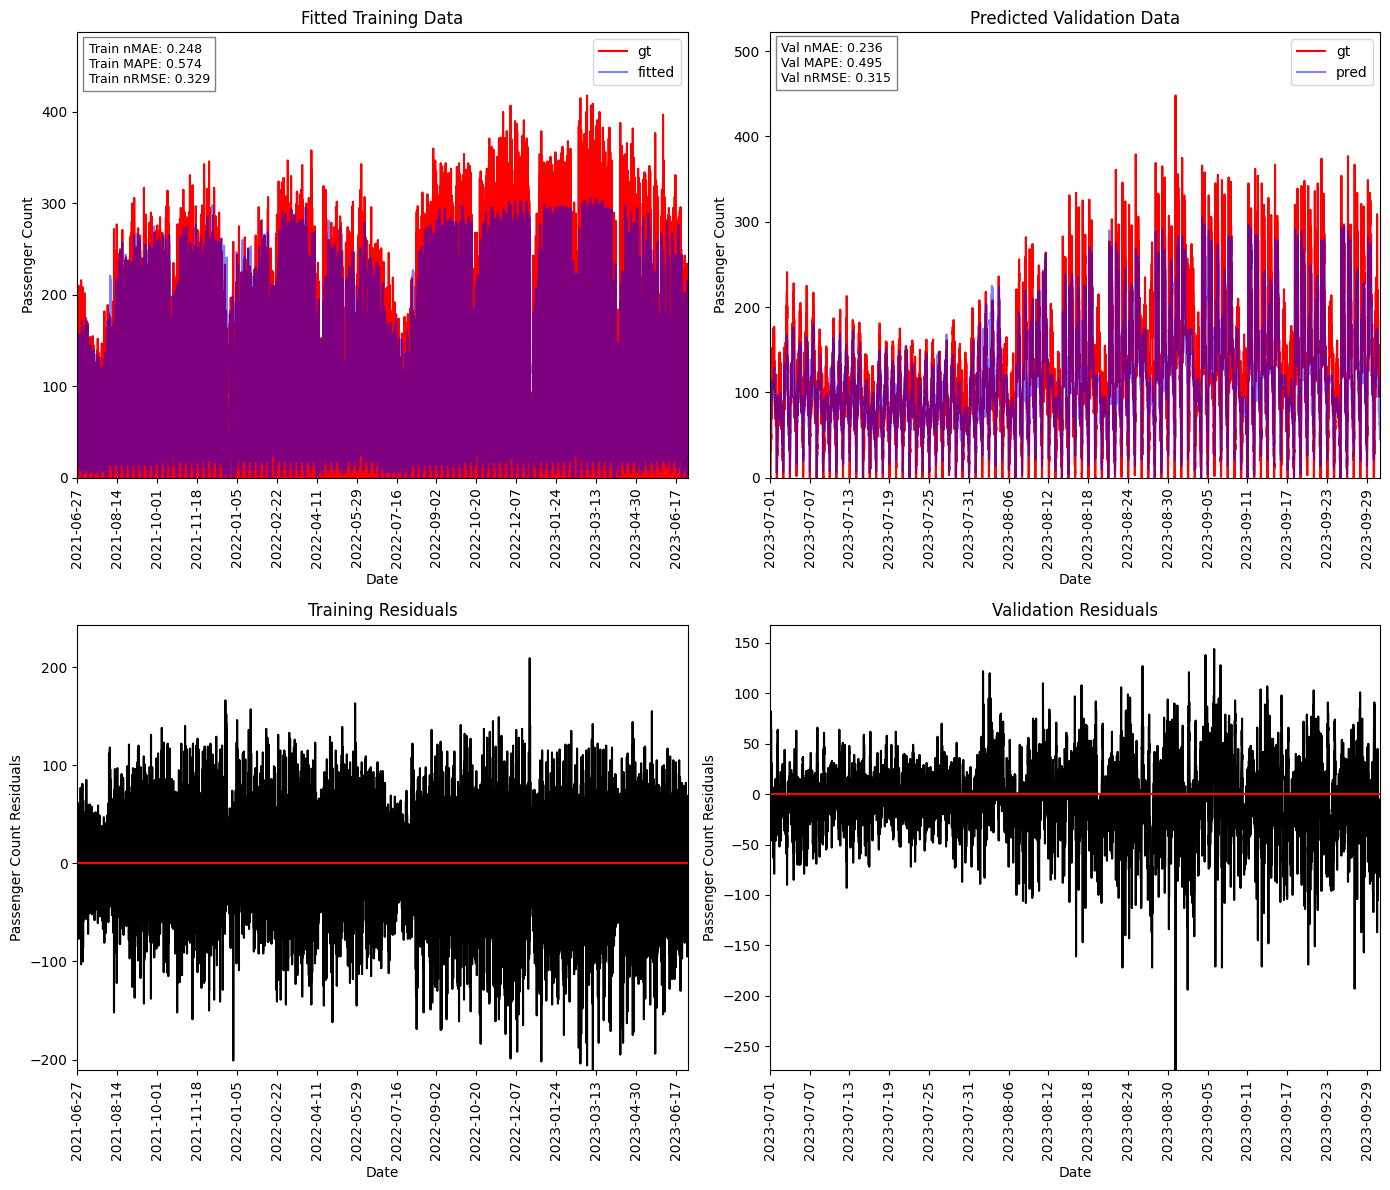

In [57]:
plotFitAndPredictions(y_train_pred, y_val_pred, y_train_true, y_val_true, trainDateCol=train_orig["date"], valDateCol=val_orig["date"])

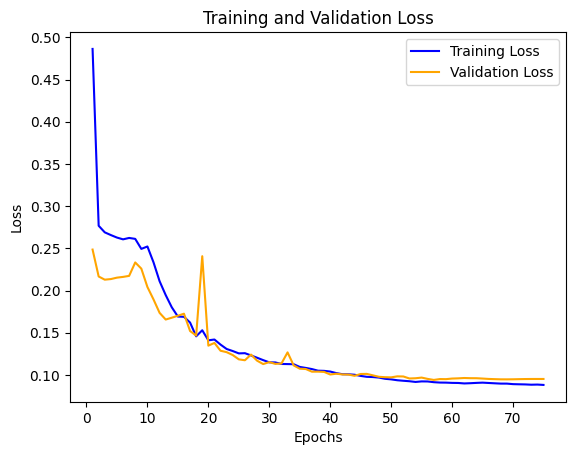

In [33]:
plotLossCurves(train_loss_list, val_loss_list, epoch_range)

## Hyperparameter search

In [10]:
# Change accordingly
aggLevel = 60

if aggLevel == 60:
    multiplier = 1
elif aggLevel == 30:
    multiplier = 2
elif aggLevel == 15:
    multiplier = 4

# Variants
windowStrategy_list = [utils.Pytorch.fixedWindowPytorch]
line_list = ["1A"]
diff_list = [True, False]
useLags_list = [False, True]
dropWeather_list = [True, False]
dropCalendar_list = [True, False]

# Base model
base_model = {"lags": [],
              "hidden_size": 60,
              "num_layers": 2,
              "dropout_prob": 0.35,
              "bidirectional": True,
              "batch_size": 480,
              "epochs": 50,
              "max_lr": 1e-3}
base_model["lags"] = [lag*multiplier for lag in base_model["lags"]]

# Grid lists
list_of_lags = [[1], [4], [8], [20], [40], [60], [80], [100], [120], [140],
                [1, 20, 140], 
                [1, 4, 8, 20],
                [1, 10, 20, 140],
                [1, 4, 8, 20, 140],
                [20, 40, 60, 80, 100, 120, 140],
                [1, 20, 40, 60, 80, 100, 120, 140]]
list_of_lags = [[lag*multiplier for lag in lags] for lags in list_of_lags]
hidden_size_list = [20, 40, 60, 80, 100]
num_layers_list = [2, 3]
dropout_prob_list = [0.1, 0.25, 0.35, 0.5, 0.75]
bidirectional_list = [True, False]
batch_size_list = [32, 160, 480, 704, 960]
max_lr_list = [1e-1, 1e-2, 1e-3, 1e-4]
epochs_list = [20, 30, 50, 75, 100]

for windowStrategy in windowStrategy_list:
    for line in line_list:
        for useLags in useLags_list:
            for dropCalendar in dropCalendar_list:
                for dropWeather in dropWeather_list:
                    if not useLags and dropCalendar and dropWeather:
                        continue

                    for diff in diff_list:
                        if useLags:
                            lags_list = deepcopy(list_of_lags)
                        else:
                            lags_list = [[]]

                        # Grid search
                        best_val_nMAE = np.Inf
                        for lags in lags_list:
                            X_train, y_train, X_val, y_val, y_train_true, y_val_true, lagColName, multiplier, train_orig, val_orig = utils.Pytorch.setupData(aggLevel,
                                                                                                                                                             multiplier,
                                                                                                                                                             line,
                                                                                                                                                             diff,
                                                                                                                                                             lags,
                                                                                                                                                             dropWeather,
                                                                                                                                                             dropCalendar)
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["lags"] = lags
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        X_train, y_train, X_val, y_val, y_train_true, y_val_true, lagColName, multiplier, train_orig, val_orig = utils.Pytorch.setupData(aggLevel,
                                                                                                                                                         multiplier,
                                                                                                                                                         line,
                                                                                                                                                         diff,
                                                                                                                                                         base_model["lags"],
                                                                                                                                                         dropWeather,
                                                                                                                                                         dropCalendar)
                        for hidden_size in hidden_size_list:
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=hidden_size, num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["hidden_size"] = hidden_size
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        for num_layers in num_layers_list:
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=base_model["hidden_size"], num_layers=num_layers, dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["num_layers"] = num_layers
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        for dropout_prob in dropout_prob_list:
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=dropout_prob, bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["dropout_prob"] = dropout_prob
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        for bidirectional in bidirectional_list:
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=bidirectional)
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["bidirectional"] = bidirectional
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        for batch_size in batch_size_list:
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=batch_size,
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["batch_size"] = batch_size
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        for max_lr in max_lr_list:
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=base_model["epochs"],
                                                                                                                                         max_lr=max_lr,
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["max_lr"] = max_lr
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        for epochs in epochs_list:
                            torch.manual_seed(42)
                            torch.cuda.manual_seed_all(42)
                            model = RNN(hidden_size=base_model["hidden_size"], num_layers=base_model["num_layers"], dropout_prob=base_model["dropout_prob"], bidirectional=base_model["bidirectional"])
                            model, y_train_pred, y_val_pred, epoch_range, train_loss_list, val_loss_list = utils.Pytorch.forecastPytorch(windowStrategy,
                                                                                                                                         X_train,
                                                                                                                                         y_train,
                                                                                                                                         X_val,
                                                                                                                                         y_val,
                                                                                                                                         y_train_true,
                                                                                                                                         y_val_true,
                                                                                                                                         model=model,
                                                                                                                                         batchSize=base_model["batch_size"],
                                                                                                                                         epochs=epochs,
                                                                                                                                         max_lr=base_model["max_lr"],
                                                                                                                                         device=device,
                                                                                                                                         lagColName=lagColName,
                                                                                                                                         horizon=40*multiplier)
                            current_val_nMAE = nMAE(y=y_val_true, yhat=y_val_pred)
                            if current_val_nMAE < best_val_nMAE:
                                best_val_nMAE = current_val_nMAE
                                base_model["epochs"] = epochs
                                best_train_nMAE = nMAE(y=y_train_true, yhat=y_train_pred)
                                best_train_MAPE = MAPE(y=y_train_true, yhat=y_train_pred)
                                best_train_nRMSE = nRMSE(y=y_train_true, yhat=y_train_pred)
                                best_val_MAPE = MAPE(y=y_val_true, yhat=y_val_pred)
                                best_val_nRMSE = nRMSE(y=y_val_true, yhat=y_val_pred)

                        with open(f"hyperparameterSearch/{model.__class__.__name__}HyperparameterSearch.txt", "a") as f:
                            f.write(f"Window: {windowStrategy.__doc__}, Line: {line}, Lags: {useLags}, Drop C: {dropCalendar}, Drop W: {dropWeather}, Diff: {diff}\n")
                            f.write("Best hyperparameters:\n")
                            f.write(f"lags: {base_model["lags"]}\n")
                            f.write(f"hidden size: {base_model["hidden_size"]}, layers: {base_model["num_layers"]}, dropout: {base_model["dropout_prob"]}, bidirectional: {base_model["bidirectional"]}\n")
                            f.write(f"batch size: {base_model["batch_size"]}, epochs: {base_model["epochs"]}, max_lr: {base_model["max_lr"]}\n")
                            f.write(f"Train metrics:\n")
                            f.write(f"nMAE: {best_train_nMAE}, MAPE: {best_train_MAPE}, nRMSE: {best_train_nRMSE}\n")
                            f.write(f"Val metrics:\n")
                            f.write(f"nMAE: {best_val_nMAE}, MAPE: {best_val_MAPE}, nRMSE: {best_val_nRMSE}\n")
                            f.write("------------------------------------------------------------------------------\n")

KeyboardInterrupt: 

1A 60min:

Diff=0

$$
\begin{array}{c|c|c|c|c|c|c|c|c}
Model & Lags & Hidden\ size & Layers & Dropout & Bidirectional & Batch\ size & Max\ LR & Epochs\\
\hline
FLstmW   & None & 80 & 3 & 0.35 & True & 32 & 10^{-3} & 50\\
\hline
FLstmC   & None & 60 & 3 & 0.35 & True & 32 & 10^{-3} & 30\\
\hline
FLstmCW  & None & 80 & 2 & 0.35 & True & 32 & 10^{-3} & 50\\
\hline
FLstmL   & [20, 40, 60, 80, 100, 120, 140] & 60 & 2 & 0.25 & True & 32 & 10^{-3} & 75\\
\hline
FLstmLW  & [20, 40, 60, 80, 100, 120, 140] & 40 & 2 & 0.25 & True & 32 & 10^{-3} & 75\\
\hline
FLstmLC  & [20, 40, 60, 80, 100, 120, 140] & 100 & 2 & 0.5 & True & 32 & 10^{-3} & 75\\
\hline
FLstmLCW & [20, 40, 60, 80, 100, 120, 140] & 60 & 2 & 0.5 & True & 32 & 10^{-3} & 100\\
\end{array}
$$


Diff=1

$$
\begin{array}{c|c|c|c|c|c|c|c|c}
Model & Lags & Hidden\ size & Layers & Dropout & Bidirectional & Batch\ size & Max\ LR & Epochs\\
\hline
FLstmW   & None & 100 & 3 & 0.35 & True & 160 & 10^{-3} & 50\\
\hline
FLstmC   & None & 60 & 3 & 0.35 & True & 32 & 10^{-3} & 50\\
\hline
FLstmCW  & None & 60 & 2 & 0.5 & True & 32 & 10^{-3} & 30\\
\hline
FLstmL   & [20, 40, 60, 80, 100, 120, 140] & 60 & 2 & 0.25 & True & 32 & 10^{-3} & 50\\
\hline
FLstmLW  & [140] & 40 & 2 & 0.25 & True & 32 & 10^{-3} & 75\\
\hline
FLstmLC  & [20, 40, 60, 80, 100, 120, 140] & 40 & 2 & 0.25 & True & 32 & 10^{-3} & 75\\
\hline
FLstmLCW & [1, 4, 8, 20, 140] & 40 & 2 & 0.5 & True & 32 & 10^{-3} & 100\\
\end{array}
$$

## Performance based Shapley Values

In [59]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from copy import copy
import re

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler

import utils.DataSplitter
import utils.Sklearn
from utils.metrics import *
from utils.ColumnEnum import Columns

import warnings

warnings.filterwarnings('ignore', category=UserWarning)

level = 60
line = Columns.line_1A.value
target = Columns.target_passengersBoarding.value

if level == 60:
    agg = 1
elif level == 30:
    agg = 2
elif level == 15:
    agg = 4

df_level = utils.DataSplitter.getTrainData(agglevel=level, diff=False)
df_level_line = df_level[df_level['line'] == line]
df_train, df_val = utils.DataSplitter.performTrainValSplit(df=df_level_line)

to_drop = [target]
X_train = utils.DataSplitter.subsetColumns(df_train, dropCategorical=True, dropLags=False, dropWeather=False, dropCalendar=False, 
                                           dropSpecific=to_drop)
y_train = df_train[target]

X_val = utils.DataSplitter.subsetColumns(df_val, dropCategorical=True, dropLags=False, dropWeather=False, dropCalendar=False, 
                                         dropSpecific=to_drop)
y_val = df_val[target]

print(all(X_train.columns == X_val.columns))
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)
print(X_train.columns)

True
(14680, 55) (14680,) (1840, 55) (1840,)
Index(['peakHour', 'Q1', 'Q2', 'Q3', 'Q4', 'mon', 'tue', 'wed', 'thu', 'fri',
       'sat', 'sun', 'workdayPlan', 'saturdayPlan', 'sundayAndHolidayPlan',
       'summerVacation', 'fallVacation', 'christmasVacation', 'winterVacation',
       'easterVacation', 'acc_precip', 'bright_sunshine', 'mean_cloud_cover',
       'mean_pressure', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed',
       'snow_depth', 'event', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6',
       'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12', 'lag13', 'lag14',
       'lag15', 'lag16', 'lag17', 'lag18', 'lag19', 'lag20', 'lag40', 'lag60',
       'lag80', 'lag100', 'lag120', 'lag140'],
      dtype='object')


In [60]:
from skorch import NeuralNetRegressor
from skorch.helper import DataFrameTransformer
from sklearn.pipeline import Pipeline

if torch.cuda.is_available():
    print("cuda")
    device = torch.device("cuda")
else:
    print("cpu")
    device = torch.device("cpu")

# Define the LSTM model
class LSTM_skorch(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=2, output_size=1, dropout_prob=0.5, bidirectional=True):
        super(LSTM_skorch, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.directions = 2 if bidirectional else 1

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*self.directions, output_size)

    def forward(self, X):
        X = X.unsqueeze(2)
        h0 = torch.zeros(self.num_layers*self.directions, X.size(0), self.hidden_size).to(X.device)
        c0 = torch.zeros(self.num_layers*self.directions, X.size(0), self.hidden_size).to(X.device)

        out, _ = self.lstm(X, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define the RNN model
class RNN_skorch(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, num_layers=3, output_size=1, dropout_prob=0.1, bidirectional=True):
        super(RNN_skorch, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.directions = 2 if bidirectional else 1

        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size*self.directions, output_size)

    def forward(self, x):
        x = x.unsqueeze(2)
        h0 = torch.zeros(self.num_layers*self.directions, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out
"""
batchSize = 32
epochs = 75
lr = 1e-3
model = LSTM_skorch(hidden_size=100, num_layers=2, dropout_prob=0.5, bidirectional=True)

# Instantiate the NeuralNetClassifier
net = NeuralNetRegressor(
    model,
    device=device,
    max_epochs=epochs,
    lr=lr,
    optimizer=torch.optim.Adam,
    criterion=torch.nn.MSELoss(reduction="mean"),
    batch_size=batchSize
)


pipe = Pipeline([
    ('transform', DataFrameTransformer()),
    ('net', net),
])

#net.fit(X_train_scaled.astype(np.float32), y_train_scaled.squeeze(1).astype(np.float32).reshape(-1, 1))
pipe.fit(X_train, np.array(y_train, dtype=np.float32).reshape(-1, 1))

y_pred = pipe.predict(X_val)
#y_pred = net.predict(X_val_scaled.astype(np.float32))
"""

cuda


'\nbatchSize = 32\nepochs = 75\nlr = 1e-3\nmodel = LSTM_skorch(hidden_size=100, num_layers=2, dropout_prob=0.5, bidirectional=True)\n\n# Instantiate the NeuralNetClassifier\nnet = NeuralNetRegressor(\n    model,\n    device=device,\n    max_epochs=epochs,\n    lr=lr,\n    optimizer=torch.optim.Adam,\n    criterion=torch.nn.MSELoss(reduction="mean"),\n    batch_size=batchSize\n)\n\n\npipe = Pipeline([\n    (\'transform\', DataFrameTransformer()),\n    (\'net\', net),\n])\n\n#net.fit(X_train_scaled.astype(np.float32), y_train_scaled.squeeze(1).astype(np.float32).reshape(-1, 1))\npipe.fit(X_train, np.array(y_train, dtype=np.float32).reshape(-1, 1))\n\ny_pred = pipe.predict(X_val)\n#y_pred = net.predict(X_val_scaled.astype(np.float32))\n'

In [61]:
import os
from anatomy import *
from copy import copy

def train_LSTM(x_train: pd.DataFrame, y_train: pd.Series) -> AnatomyModel:
    batchSize = 32
    epochs = 75
    lr = 1e-3
    model = LSTM_skorch(hidden_size=100, num_layers=2, dropout_prob=0.5, bidirectional=True)

    # Instantiate the NeuralNetClassifier
    LSTM_model = NeuralNetRegressor(
        model,
        device=device,
        max_epochs=epochs,
        lr=lr,
        optimizer=torch.optim.Adam,
        criterion=torch.nn.MSELoss(reduction="mean"),
        batch_size=batchSize
    )

    LSTM_pipe = Pipeline([
        ('transform', DataFrameTransformer()),
        ('net', LSTM_model),
    ])

    #LSTM_model.fit(x_train, y_train)
    LSTM_pipe.fit(x_train, np.array(y_train, dtype=np.float32).reshape(-1, 1))

    def pred_fn_xgb(xs: np.ndarray) -> np.ndarray:
        xs_df = pd.DataFrame(xs, columns=x_train.columns)
        #return np.array(LSTM_model.predict(xs_df)).flatten()
        return np.array(LSTM_pipe.predict(xs_df)).flatten()

    return AnatomyModel(pred_fn_xgb)


def generate_data(n_predictors=3) -> [pd.DataFrame, AnatomySubsets]:
    xy = copy(pd.concat([X_train, X_val]))
    scalar = StandardScaler()
    xy = pd.DataFrame(scalar.fit_transform(xy), columns=xy.columns)

    xy['y'] = copy(pd.concat([y_train, y_val]))
    for i in [20, 40, 60, 80, 100, 120, 140]:
        xy[f'{i}'] = xy['y'].shift(periods=i).fillna(0)

    subsets = AnatomySubsets.generate(
        index=xy.index,
        initial_window=X_train.shape[0],
        estimation_type=AnatomySubsets.EstimationType.EXPANDING,
        periods=1,
        gap=0
    )

    return xy, subsets

def estimate_anatomy(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    def mapper(key: AnatomyModelProvider.PeriodKey) -> \
            AnatomyModelProvider.PeriodValue:
        train = xy.iloc[subsets.get_train_subset(key.period)]
        test = xy.iloc[subsets.get_test_subset(key.period)]

        if key.model_name == "lstm":
            model = train_LSTM(train.drop("y", axis=1), train["y"])

        return AnatomyModelProvider.PeriodValue(train, test, model)

    provider = AnatomyModelProvider(
        n_periods=subsets.n_periods,
        n_features=xy.shape[1] - 1,
        model_names=["lstm"],
        y_name="y",
        provider_fn=mapper
    )

    Anatomy(provider=provider, n_iterations=5).precompute(
        n_jobs=max(1, min(os.cpu_count(), 16)), save_path="anatomyLSTMval.bin"
    )


def anatomize(xy: pd.DataFrame, subsets: AnatomySubsets) -> None:
    anatomy = Anatomy.load("anatomyLSTMval.bin")
    groups = {
        "lstm": ["lstm"]
    }

    def anatomize_mae() -> pd.DataFrame:
        def transform(y_hat, y):
            return nMAE(y=y, yhat=y_hat)

        return anatomy.explain(
            model_sets=AnatomyModelCombination(groups=groups),
            transformer=AnatomyModelOutputTransformer(transform=transform)
        )

    pd.options.display.width = 0  # to print all columns

    tmpl = "contributions to %s:"
    anatomized_mae = anatomize_mae()
    print(tmpl % "mean absolute error")
    print(anatomized_mae, "\n")
    return anatomized_mae


# set random seed for reproducibility:
np.random.seed(42)
xy, subsets = generate_data()
estimate_anatomy(xy, subsets)

# load anatomy bin and calculate shapley values
anatomized_mae = anatomize(xy, subsets)

with open("LSTMAnatomizeDone.txt", "a") as f:
    f.write("Done!")

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.


KeyboardInterrupt: 

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch gradient descent (100 epochs)
MAE: 1158.678

RMSE: 1559.774

Train loss: 0.3219127655029297

Validation loss: 0.29513391852378845

### Batch size = 1468 / 10 batches (100 epochs)
MAE: 800.15

RMSE: 1069.872

Train loss: 0.13537027463316917

Validation Loss: 0.14593974500894547

### Batch size = 978 / 15 batches (100 epochs)
MAE: 792.168

RMSE: 1059.725

Train loss: 0.13312541443156078

Validation Loss: 0.1379912607371807

### Batch size = 734 / 20 batches (100 epochs)
MAE: 792.649

RMSE: 1044.83

Train loss: 0.11595435291528702

Validation Loss: 0.1367316817243894

### Batch size = 489 / 30 batches (100 epochs)
MAE: 815.339

RMSE: 1095.619

Train loss: 0.12239421086926613

Validation Loss: 0.14689216017723083

### Batch size = 32 (100 epochs)
MAE: 864.641

RMSE: 1151.149

Train loss: 0.04935611497553995

Validation Loss: 0.16076639365276385

## lr = 10^-3, hidden_size = 50, n_layers = 4

### Batch size = 978 / 15 batches (100 epochs)
MAE: 796.149

RMSE: 1072.83

Train Loss: 0.11068850380252115

Validation Loss: 0.14133882895112038

### Batch size = 734 / 20 batches (100 epochs)
MAE: 801.216

RMSE: 1067.93

Train loss: 0.10946012996137142

Validation Loss: 0.13967678447564444

# Method

- Implemented LSTM with Adam optimizer, lr=10^-3, hidden_size=50, n_layers=2

- Implemented the ability to take minibatches and then tried hidden_size=100&n_layers=2, hidden_size=50&n_layers=4 and hidden_size=100&n_layers=4

- Implemented dropout as regularization, since it was overfitting on smaller batchsizes

- Implemented bi-directional LSTM

- Implemented lr scheduler